# Sample DCGAN Implementation using Keras

To illustrate the implementation of a GAN using Python, we use the [Deep Convolutional GAN](https://arxiv.org/abs/1511.06434 (DCGAN) example discussed in the Section 'Evolution of GAN Architectures' to synthesize images from the fashion MNIST dataset. 

Adapted from https://github.com/eriklindernoren/Keras-GAN/blob/master/dcgan/dcgan.py

## Imports & Settings

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import warnings
import sys
import numpy as np

from keras.datasets import mnist, fashion_mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
warnings.filterwarnings('ignore')

In [3]:
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)
latent_dim = 100

In [5]:
epochs=4000
batch_size=128
save_interval=50
progress_every = 100

## Helper

In [6]:
def save_imgs(epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, latent_dim))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig('images/fashion_mnist_{}.png'.format(epoch))

## Build Discriminator

Both the discriminator and generator use a deep CNN architecture, wrapped in a function:

In [7]:
def build_discriminator():
    model = Sequential([
        Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding='same'),
        LeakyReLU(alpha=0.2),
        Dropout(0.25),
        Conv2D(64, kernel_size=3, strides=2, padding='same'),
        ZeroPadding2D(padding=((0, 1), (0, 1))),
        BatchNormalization(momentum=0.8),
        LeakyReLU(alpha=0.2),
        Dropout(0.25),
        Conv2D(128, kernel_size=3, strides=2, padding='same'),
        BatchNormalization(momentum=0.8),
        LeakyReLU(alpha=0.2),
        Dropout(0.25),
        Conv2D(256, kernel_size=3, strides=1, padding='same'),
        BatchNormalization(momentum=0.8),
        LeakyReLU(alpha=0.2),
        Dropout(0.25),
        Flatten(),
        Dense(1, activation='sigmoid')
    ])

    model.summary()

    img = Input(shape=img_shape)
    validity = model(img)

    return Model(img, validity)

A call to this function and subsequent compilation shows that this network has over 393,000 parameters.

In [4]:
optimizer = Adam(0.0002, 0.5)

Instructions for updating:
Colocations handled automatically by placer.


In [8]:
# Build and compile the discriminator
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',
                           optimizer=optimizer,
                           metrics=['accuracy'])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 8, 8, 64)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 64)          256       
___________________________

## Build Generator

The generator network is slightly shallower but has more than twice as many parameters:

In [9]:
def build_generator():
    model = Sequential([
        Dense(128 * 7 * 7, activation='relu', input_dim=latent_dim),
        Reshape((7, 7, 128)),
        UpSampling2D(),
        Conv2D(128, kernel_size=3, padding='same'),
        BatchNormalization(momentum=0.8),
        Activation('relu'),
        UpSampling2D(),
        Conv2D(64, kernel_size=3, padding='same'),
        BatchNormalization(momentum=0.8),
        Activation('relu'),
        Conv2D(channels, kernel_size=3, padding='same'),
        Activation('tanh')])

    model.summary()
    noise = Input(shape=(latent_dim,))
    img = model(noise)

    return Model(noise, img)

In [10]:
# Build the generator
generator = build_generator()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 6272)              633472    
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 128)       147584    
_________________________________________________________________
batch_normalization_4 (Batch (None, 14, 14, 128)       512       
_________________________________________________________________
activation_1 (Activation)    (None, 14, 14, 128)       0         
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 28, 28, 128)       0         
__________

## Create Combined Model

The combined model consists of the stacked generator and discriminator and trains the former to fool the latter:

In [11]:
# The generator takes noise as input and generates imgs
z = Input(shape=(latent_dim,))
img = generator(z)

# For the combined model we will only train the generator
discriminator.trainable = False

# The discriminator takes generated images as input and determines validity
valid = discriminator(img)

# The combined model  (stacked generator and discriminator)
# Trains the generator to fool the discriminator
combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

## Load the Data

In [12]:
# Load the dataset
(X_train, _), (_, _) = fashion_mnist.load_data()

# Rescale -1 to 1
X_train = X_train / 127.5 - 1.
X_train = np.expand_dims(X_train, axis=3)

## Adversarial Training

Adversarial training iterates over the epochs, generates random image and noise input, and trains both the discriminator and the generator (as part of the combined model):

In [13]:
# Adversarial ground truths
valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

Instructions for updating:
Use tf.cast instead.
    0 | Discriminator Loss: 1.1500  Accuracy: 32.42% | Generator Loss: 0.7232
  100 | Discriminator Loss: 0.8362  Accuracy: 50.00% | Generator Loss: 1.1875
  200 | Discriminator Loss: 0.6351  Accuracy: 64.84% | Generator Loss: 1.2165
  300 | Discriminator Loss: 0.7033  Accuracy: 55.86% | Generator Loss: 1.1464
  400 | Discriminator Loss: 0.6380  Accuracy: 65.23% | Generator Loss: 1.1279
  500 | Discriminator Loss: 0.6816  Accuracy: 59.38% | Generator Loss: 1.1778
  600 | Discriminator Loss: 0.6978  Accuracy: 59.38% | Generator Loss: 1.0102
  700 | Discriminator Loss: 0.6460  Accuracy: 64.84% | Generator Loss: 1.1709
  800 | Discriminator Loss: 0.6652  Accuracy: 59.77% | Generator Loss: 1.0554
  900 | Discriminator Loss: 0.6856  Accuracy: 56.64% | Generator Loss: 1.0876
1,000 | Discriminator Loss: 0.6649  Accuracy: 60.94% | Generator Loss: 1.0400
1,100 | Discriminator Loss: 0.6843  Accuracy: 61.33% | Generator Loss: 1.0122
1,200 | Discrimi

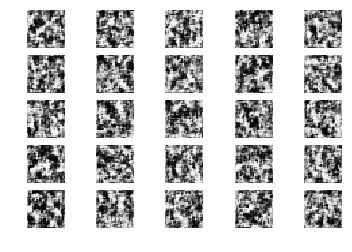

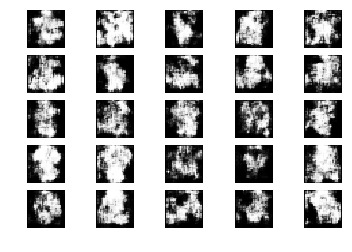

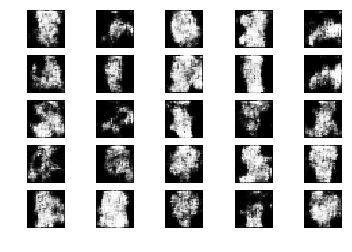

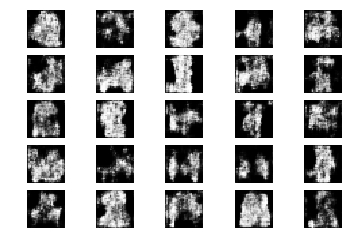

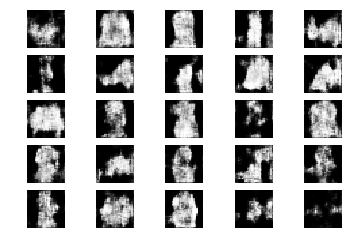

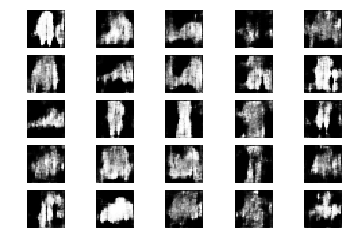

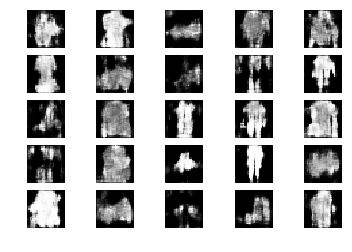

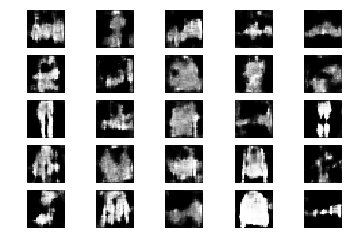

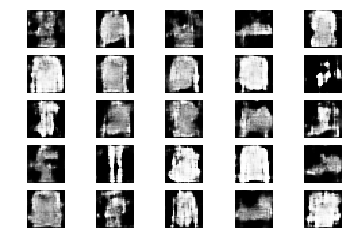

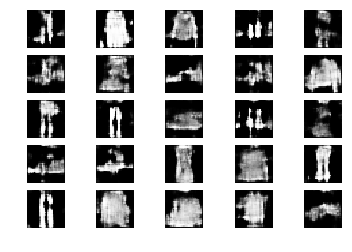

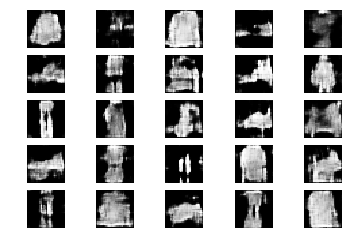

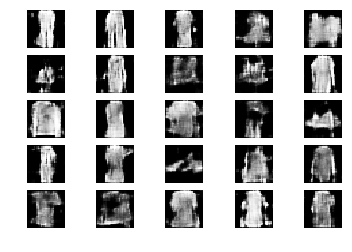

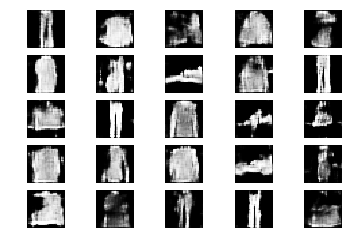

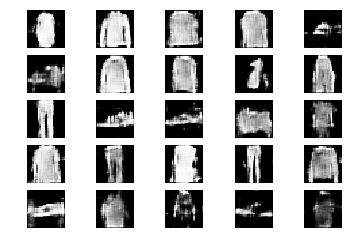

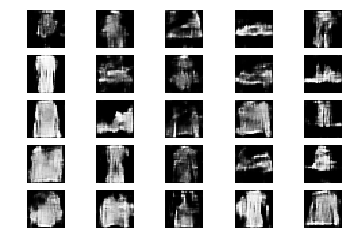

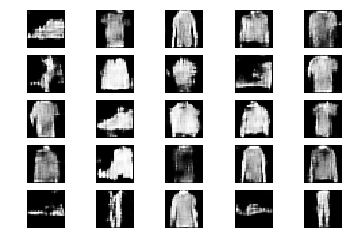

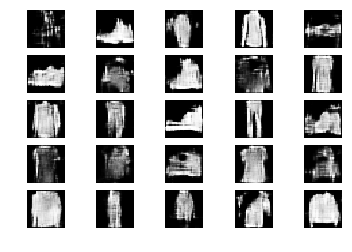

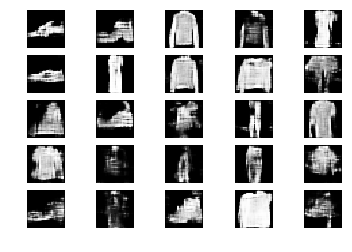

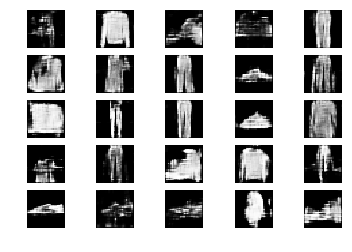

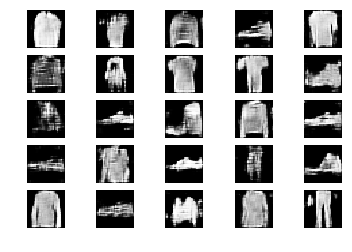

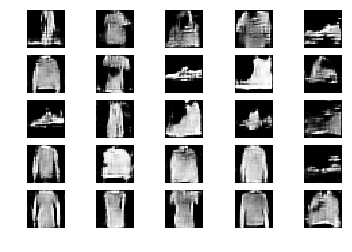

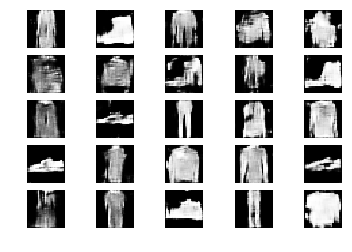

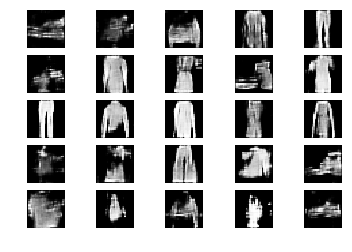

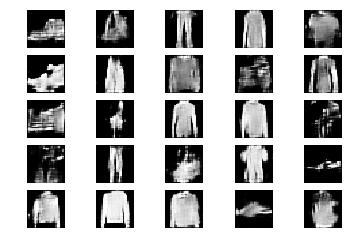

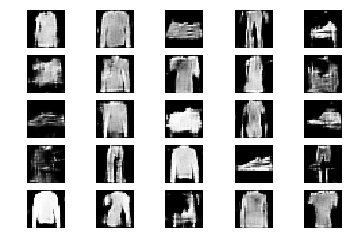

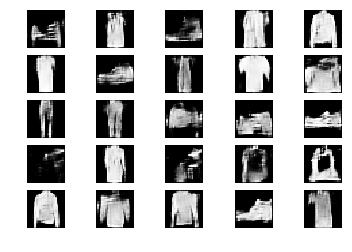

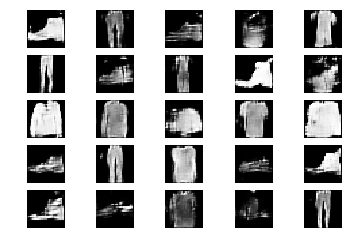

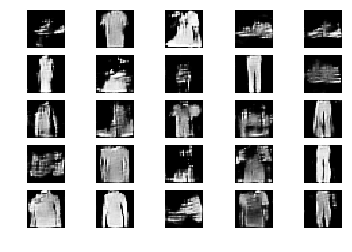

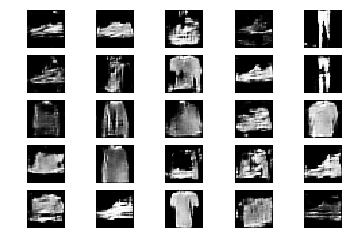

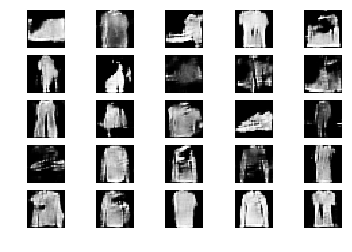

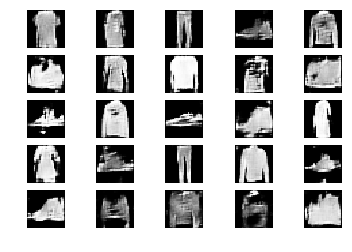

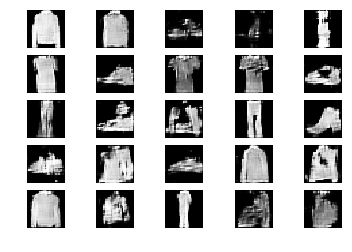

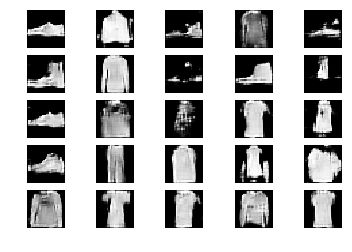

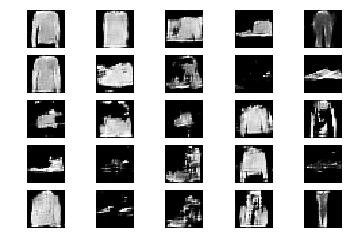

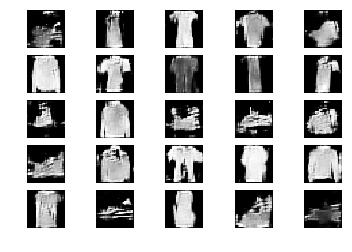

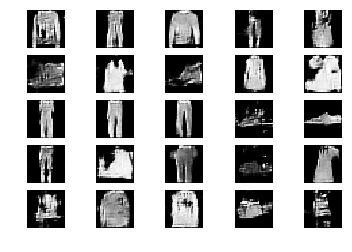

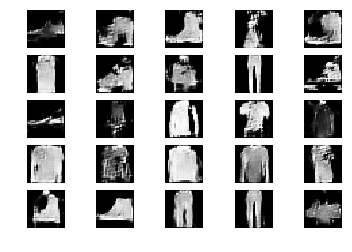

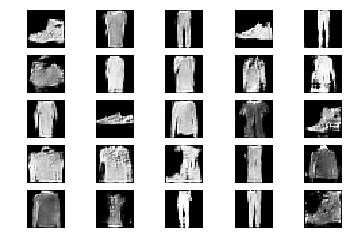

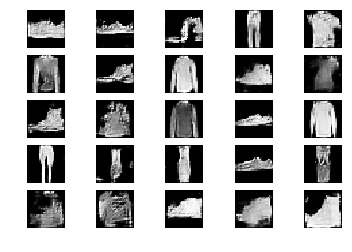

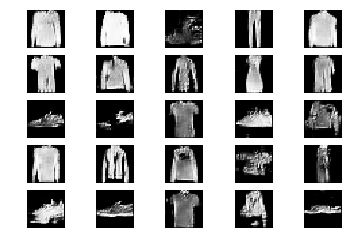

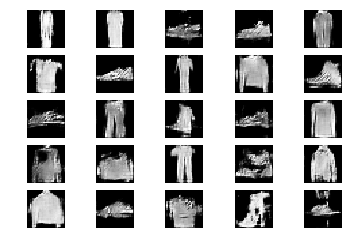

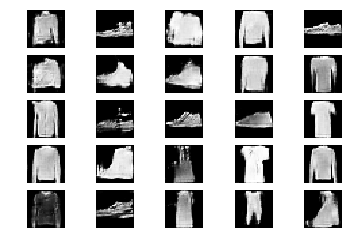

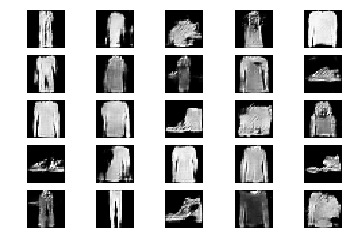

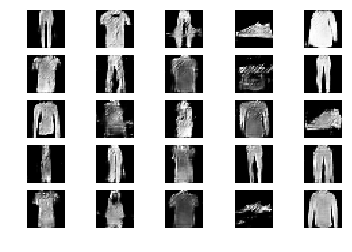

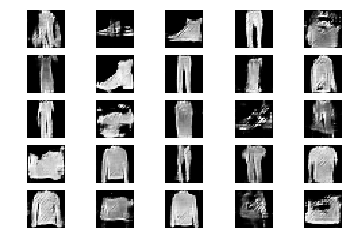

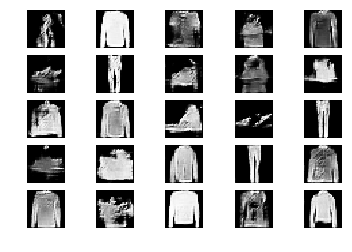

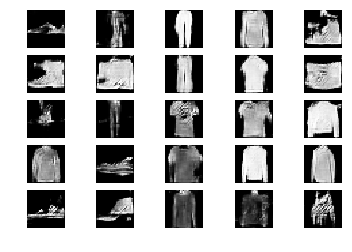

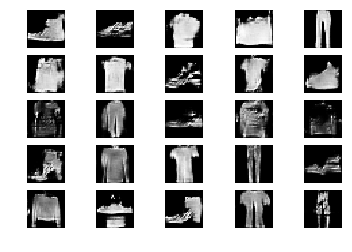

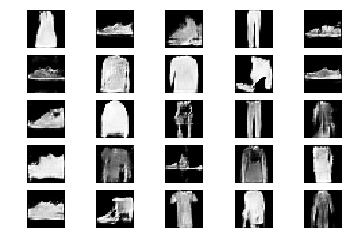

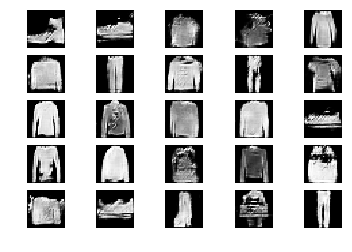

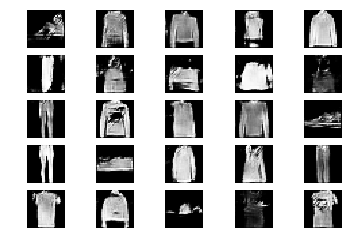

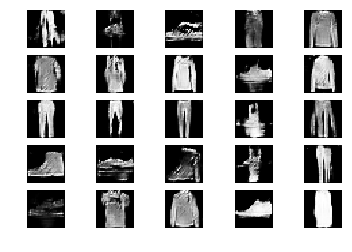

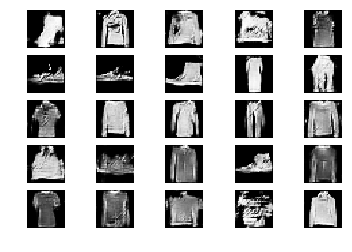

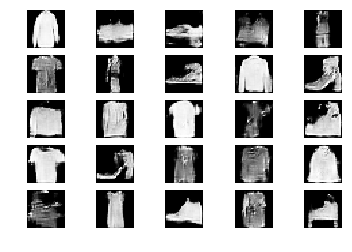

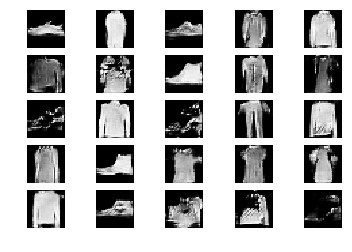

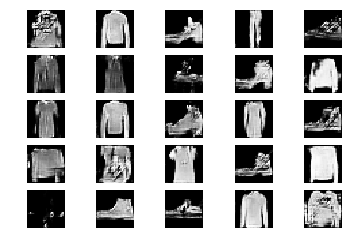

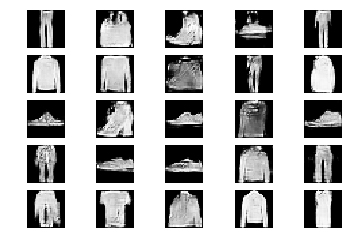

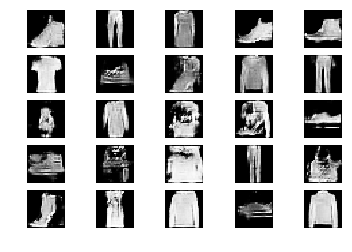

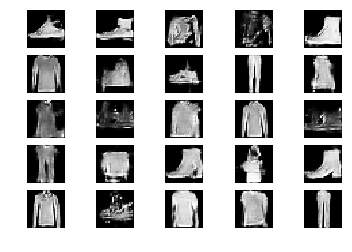

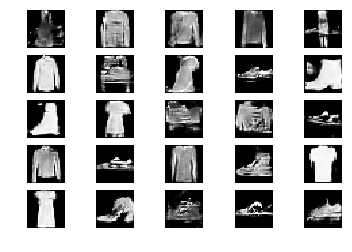

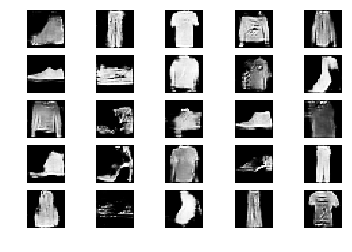

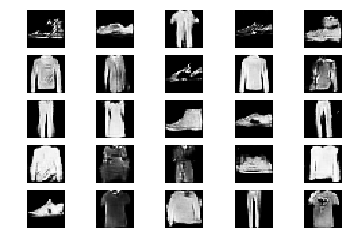

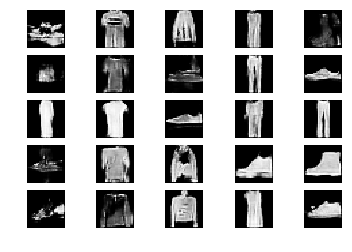

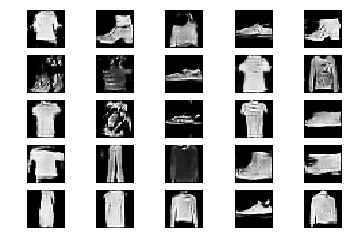

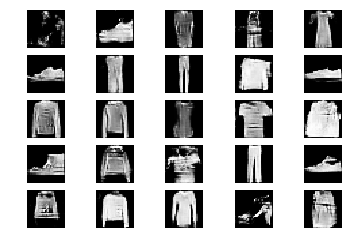

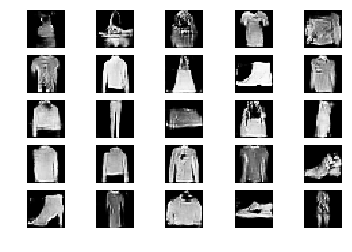

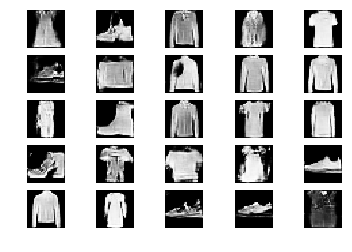

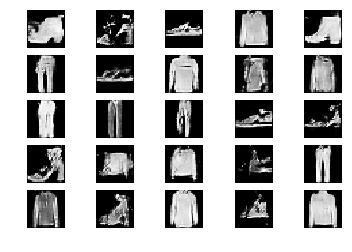

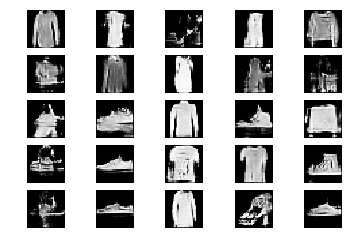

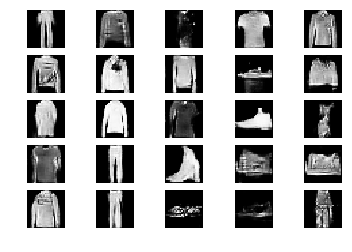

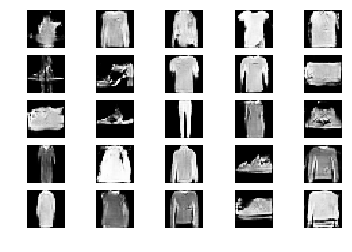

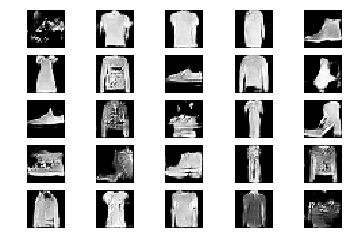

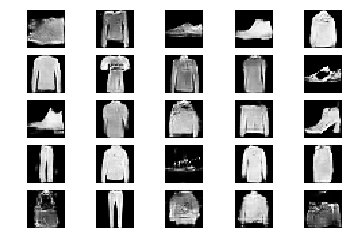

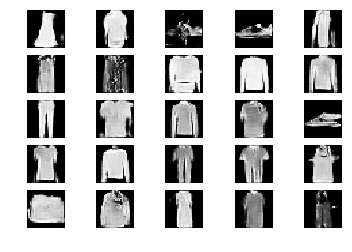

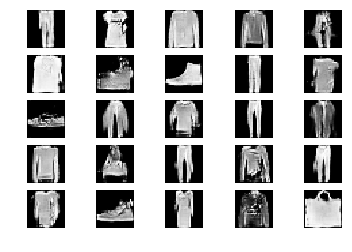

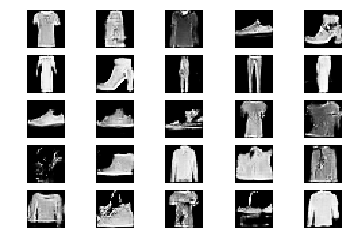

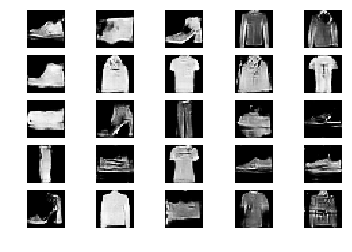

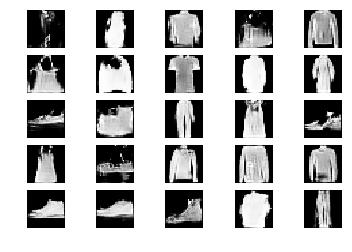

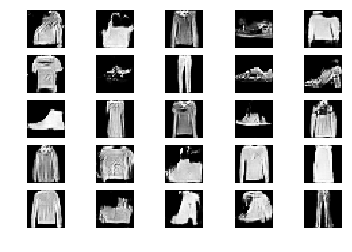

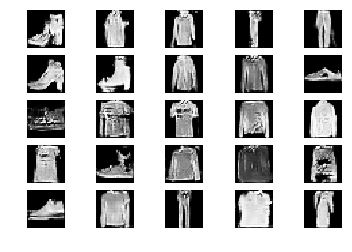

In [14]:
for epoch in range(epochs):
    # Select a random half of images
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs = X_train[idx]

    # Sample noise and generate a batch of new images
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    gen_imgs = generator.predict(noise)

    # Train the discriminator (real classified as ones and generated as zeros)
    d_loss_real = discriminator.train_on_batch(imgs, valid)
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Train the generator (wants discriminator to mistake images as real)
    g_loss = combined.train_on_batch(noise, valid)

    # Plot the progress
    if epoch % progress_every == 0:
        output = f'{epoch:5,d} | Discriminator Loss: {d_loss[0]:.4f}  '
        output += f'Accuracy: {d_loss[1]:.2%} | Generator Loss: {g_loss:.4f}'
        print(output)

    # If at save interval => save generated image samples
    if epoch % save_interval == 0:
        save_imgs(epoch)

After 4,000 epochs, which only takes a few minutes, the synthetic images created from random noise clearly resemble the originals:

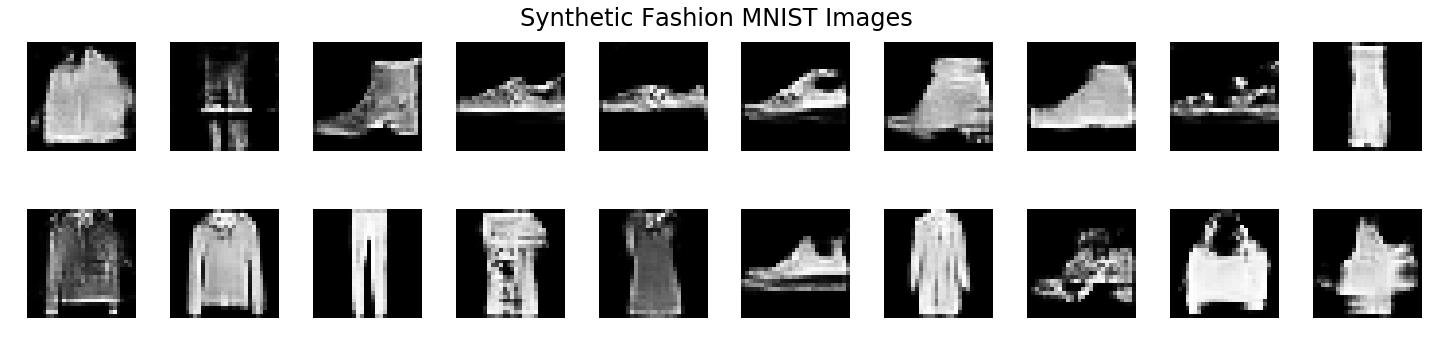

In [15]:
r, c = 2, 10
noise = np.random.normal(0, 1, (r * c, latent_dim))
gen_imgs = generator.predict(noise)

# Rescale images 0 - 1
gen_imgs = 0.5 * gen_imgs + 0.5

fig, axs = plt.subplots(r, c, figsize=(20, 5))
cnt = 0
for i in range(r):
    for j in range(c):
        axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
        axs[i,j].axis('off')
        cnt += 1

fig.suptitle('Synthetic Fashion MNIST Images', fontsize=24),
fig.tight_layout()
fig.subplots_adjust(top=.96)
fig.savefig('images/fashion_mnist.png', dpi=300)